## Set up

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, BatchNormalization
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences

## Load Dataset

In [4]:
movie_reviews = pd.read_csv(r'../resources/IMDB Dataset.csv')

In [6]:
movie_reviews.shape

(50000, 2)

## Tiền xử lý

In [5]:
# Tiền xử lý 
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text): # loại bỏ các thẻ html

    return TAG_RE.sub('', text)
    

class CustomPreprocess():
    

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()
        
        # loại bỏ các thẻ html
        sentence = remove_tags(sen)

        # loại bỏ các ký tự đặc biệt
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        # loại bỏ các ký tự đơn lẻ
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  

        # loại bỏ khoảng trắng
        sentence = re.sub(r'\s+', ' ', sentence)  
        
        # loại bỏ stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)
        
        return sentence

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:

X = []
custom = CustomPreprocess()
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(custom.preprocess_text(sen))

In [8]:
# chuyển đổi sentiment thành dạng số

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
# Lớp embedding của keras cho phép chúng ta chuyển đổi các từ thành các vector số
# Phương thức fit_on_text sẽ tạo ra một từ điển từ các từ trong tập dữ liệu
# Phương thức texts_to_sequences sẽ chuyển đổi các câu thành các chuỗi số

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [11]:
import io
import json

# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('../resources/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [13]:
# Thêm 1 để lưu trữ kích thước cho các từ mà không có embedding từ trước

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [14]:
# Để đảm bảo rằng tất cả các câu có cùng độ dài, chúng ta sẽ sử dụng phương thức pad_sequences của keras để thêm các giá trị 0 vào các câu ngắn hơn

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
# Sử dụng các vector từ GloVe để tạo ra một ma trận embedding cho các từ trong tập dữ liệu

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('../resources/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
# Tạo ma trận embedding có 100 cột 
# Chứa các vector 100 chiều của GloVe cho tất cả các từ trong tập dữ liệuiệu

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
embedding_matrix.shape

(92394, 100)

## Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D

CNN = Sequential([
    Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),

    # First Conv1D Block
    Conv1D(128, 5, activation='relu'),
    BatchNormalization(),  # Batch Normalization
    Dropout(0.3),          # Dropout for regularization

    # Global Pooling and Dense Layers
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.3),                  # Dropout before output
    Dense(1, activation='sigmoid') # Output layer
])

In [24]:
CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(CNN.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [25]:
# Model training

CNN_history = CNN.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.6540 - loss: 0.8885 - val_accuracy: 0.7325 - val_loss: 0.5224
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8047 - loss: 0.4257 - val_accuracy: 0.8340 - val_loss: 0.4018
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8369 - loss: 0.3694 - val_accuracy: 0.8414 - val_loss: 0.3799
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8486 - loss: 0.3458 - val_accuracy: 0.8456 - val_loss: 0.3595
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8614 - loss: 0.3227 - val_accuracy: 0.8454 - val_loss: 0.3558
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8676 - loss: 0.3091 - val_accuracy: 0.8464 - val_loss: 0.3459


In [26]:
# Predictions on the Test Set

score = CNN.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8408 - loss: 0.3480


In [27]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.35142576694488525
Test Accuracy: 0.8402000069618225


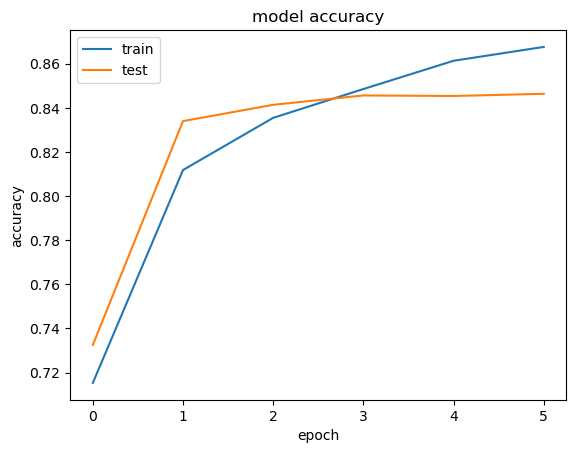

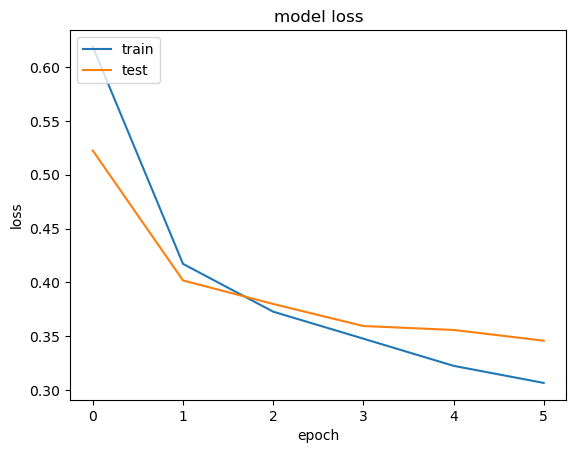

In [28]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Bidirectional Long Short-Term Memory Network

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, Conv1D

# Corrected BiLSTM Model
BiLSTM = Sequential([
    Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    
    # First BiLSTM Layer
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),  
    
    # Second BiLSTM Layer
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),  
    
    # Conv1D Layer
    Conv1D(100, 5, activation='relu'),
    
    # GlobalMaxPooling1D Layer
    GlobalMaxPooling1D(),
    
    # Dense Layers
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.3),                  # Dropout for regularization
    Dense(1, activation='sigmoid') # Output layer for binary classification
])
# Compile the model
BiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
# Model summary (optional)
BiLSTM.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [53]:
# Huấn luyên mô hình
BiLSTM_history = BiLSTM.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 175s 667ms/step - accuracy: 0.6712 - loss: 0.5848 - val_accuracy: 0.7960 - val_loss: 0.4409
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 151s 604ms/step - accuracy: 0.7838 - loss: 0.4627 - val_accuracy: 0.8278 - val_loss: 0.3825
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 626ms/step - accuracy: 0.8180 - loss: 0.4057 - val_accuracy: 0.8469 - val_loss: 0.3539
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 190s 759ms/step - accuracy: 0.8254 - loss: 0.3885 - val_accuracy: 0.8515 - val_loss: 0.3389
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 579ms/step - accuracy: 0.8381 - loss: 0.3684 - val_accuracy: 0.8600 - val_loss: 0.3295
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 168s 671ms/step - accuracy: 0.8469 - loss: 0.3509 - val_accuracy: 0.8612 - val_loss: 0.3196


In [54]:
score = BiLSTM.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8606 - loss: 0.3139


In [55]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3177317976951599
Test Accuracy: 0.8592000007629395


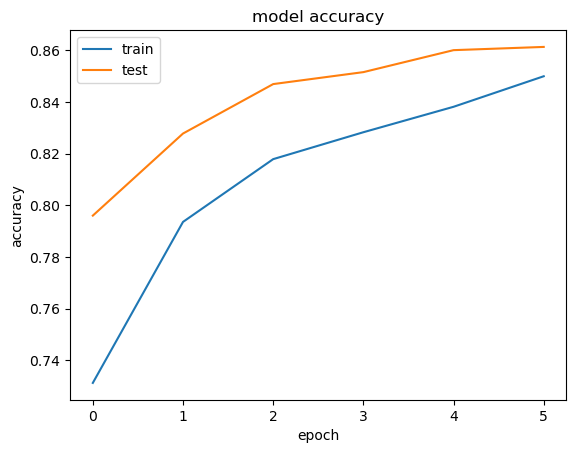

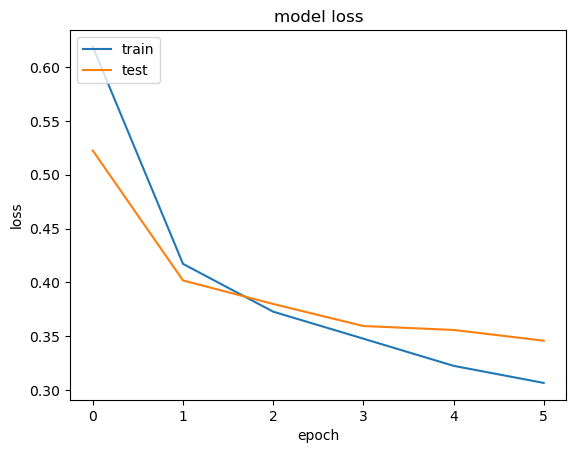

In [56]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(BiLSTM_history.history['accuracy'])
plt.plot(BiLSTM_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()